In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Functions from before

##### Choice models

In [2]:
def inequity_aversion(params, offer):
    
    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = [offer, 0]
    inequities = [(100-offer)-offer, 0]
    utilities = payoffs - np.multiply(params[0],inequities)
    choice = np.where(utilities == np.max(utilities))[0][0]

    return choice

In [3]:
def random_model(params, offer):
    
    choice = np.random.randint(0,2)
    
    return choice

##### Simulation code

In [4]:
def simulate_model(model, data_to_simulate, params = None):
    
    # Input variables: ...asdoaijsoiajc
    
    # Create output dataframe
    simulation_results = data_to_simulate.copy()
    
    # Loop over trials and simulate each trial
    for trial in data_to_simulate['trial']:
        offer = data_to_simulate.loc[data_to_simulate['trial']==trial, 'offer'].values[0]
        predicted_choice = model(params, offer)
        # store in output dataframe:
        simulation_results.loc[data_to_simulate['trial']==trial,'choice'] = predicted_choice
        
    return simulation_results

In [5]:
def plot_simulation(simulated_sub_data):
    
    fig = sns.scatterplot(data = simulated_sub_data, x = 'offer', y = 'choice')
    
    return fig

## Plan

1. Think about how to define 'model fit', i.e. when is a model good?
2. Computing model fit for a given model
3. Comparing model fit across participants and models

## Load some data

In [6]:
data_dir = '/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial/Data/Joey'

In [7]:
data = pd.read_csv(data_dir + '/Study1_UG_Data.csv')
data = data[['sub','trial','unfairness','choice']]
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


## 1.How to define model fit?

Let's start with a metric of model fit that you might know from regression: the sum of squared error (SSE).

## Compute model fit for our two models

- Step 1: plot a model + some data to see how well they overlap
- Step 2: compute the model fit

In [80]:
# Load data for a subject
sub = 20
sub_data = data.query('sub == %i'%sub)[['trial','offer','choice']]
sub_data.head()

,trial,offer,choice
380,1,30,0
381,2,45,0
382,3,20,1
383,4,40,0
384,5,40,0


[(-0.1, 1.1),
 Text(0, 0.5, 'choice'),
 Text(0.5, 0, 'offer'),
 Text(0.5, 1.0, 'SIMULATION')]

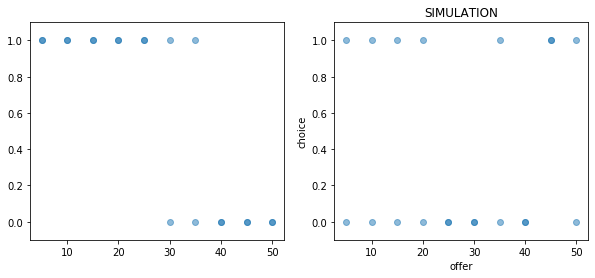

In [81]:
# Make a figure with two axes
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [10,4])

# Plot data
axes[0].scatter(x = sub_data['offer'], y = sub_data['choice'], alpha = .5)
axes[0].set(ylim = [-.1,1.1])

# Simulating the model
data_to_simulate = sub_data.copy()
simulated_data = simulate_model(random_model, data_to_simulate)

# Plot the model
axes[1].scatter(x = simulated_data['offer'], y = simulated_data['choice'], alpha = .5)
axes[1].set(title = 'SIMULATION', xlabel = 'offer', ylabel = 'choice', ylim = [-.1,1.1])

##### Compute model fit for random model

Sum of squared error = 12


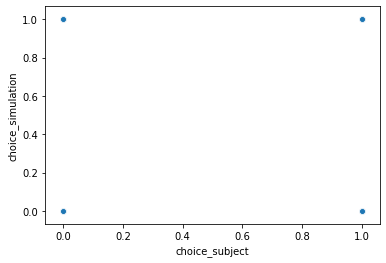

In [82]:
# Model fit = sum of squared errors

# First merge the two dataframes to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
total_data

# So first compute errors:
errors = total_data['choice_subject'] - total_data['choice_simulation']
errors

# Compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

sns.scatterplot(data = total_data, x = 'choice_subject', y = 'choice_simulation')

In [83]:
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

8 hits


##### Compute model fit for inequity aversion model

In [84]:
simulated_data = simulate_model(inequity_aversion, data_to_simulate, [2])

In [85]:
# Model fit = sum of squared errors

# First merge the two dataframes to make sure the offers match up:
total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
total_data

# So first compute errors:
errors = total_data['choice_subject'] - total_data['choice_simulation']
errors

# Compute the sum of squared errors:
SSE = np.sum(np.square(errors))
print('Sum of squared error = %i'%SSE)

# Compute number of hits
total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
hits = np.sum(total_data['correct'])
print('%i hits'%hits)

Sum of squared error = 2
18 hits


In this case, the SSE and the number of hits are perfectly correlated (hits = 20 - SSE), so we can pick just one.

##### Compute the model fit for many different values of alpha

In [86]:
range_of_alphas = np.arange(0,10,.1)

model_results = pd.DataFrame(columns=['alpha','hits'])

for alpha in range_of_alphas:
    
    # Simulate the model
    simulated_data = simulate_model(inequity_aversion, data_to_simulate, [alpha])
    
    # Merge observed and simulated data
    total_data = sub_data.merge(simulated_data, on = ['trial','offer'], suffixes = ['_subject', '_simulation'])
    
    # Compute hits
    total_data['correct'] = total_data['choice_subject'] == total_data['choice_simulation']
    hits = np.sum(total_data['correct'])
    
    # Store result
    tmp = pd.DataFrame([[alpha,hits]], columns=model_results.columns)
    model_results = model_results.append(tmp)

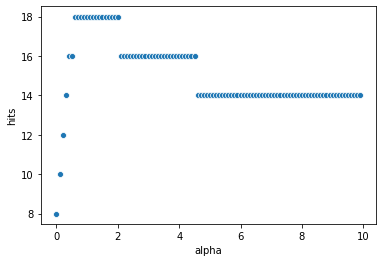

In [87]:
sns.scatterplot(data = model_results, x = 'alpha', y = 'hits')
# best_alpha = 

This plot shows you the value of alpha where you get the maximum number of hits, i.e. the best 'model fit'!

## In preparation for next session:

- Clean up the functions (make them efficient, take out unnecessary steps, add code comments (!))
- For each subject, fit the model with different alphas and record the best value of alpha
- Visualize the spread of alpha across subjects

## During next session, we will:

- Talk about different choice rules (Softmax, epsilon-greedy)
- Talk about different model fit metrics